# End to end Fapiao image recognition and key information extraction

First, import libs and init OCR module from PaddleHub

In [98]:
import paddlehub as hub
import paddle
import cv2
import numpy as np
import base64
import yaml
import pandas as pd
from matplotlib import pyplot as plt

from ppocr.data import create_operators, transform
from ppocr.utils.save_load import load_model
from ppocr.modeling.architectures import apply_to_static, build_model

paddle.set_device("cpu")
ocr_module = hub.Module(name='chinese_ocr_db_crnn_mobile', enable_mkldnn=False)

[2022-08-31 16:09:15,094] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object


Load fapiao image from disk

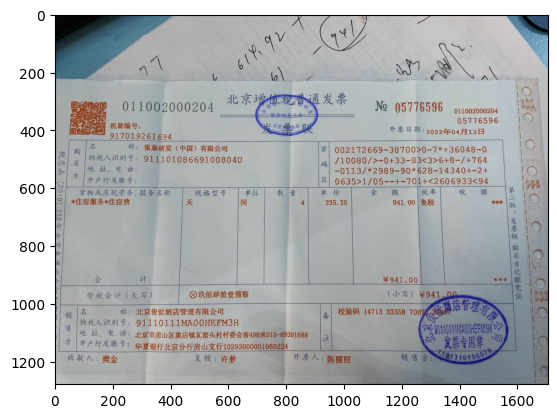

In [93]:
img = cv2.imread('./notebooks/fapiao.jpg')
plt.imshow(img)

Pass the fapiao image to OCR module and get inference result

In [102]:
ocr_res = ocr_module.recognize_text([img])
pd.DataFrame([data for data in ocr_res[0]["data"]])

[2022-08-31 16:13:02,344] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object


,text,confidence,text_box_position
0,北京增值税蓄通发票,0.889521,"[[591, 270], [1012, 270], [1012, 321], [591, 3..."
1,011002000204,0.997334,"[[231, 296], [549, 302], [549, 342], [231, 336]]"
2,Ne05776596,0.926796,"[[1100, 291], [1347, 296], [1347, 348], [1100,..."
3,011002000204,0.997022,"[[1380, 321], [1533, 321], [1533, 346], [1380,..."
4,国家税,0.726022,"[[749, 340], [797, 340], [797, 354], [749, 354]]"
5,05776596,0.997629,"[[1391, 355], [1533, 355], [1533, 380], [1391,..."
6,机器编号：,0.987644,"[[190, 373], [296, 373], [296, 399], [190, 399]]"
7,开票日期：2022年04月13日,0.973285,"[[1151, 374], [1490, 388], [1489, 432], [1149,..."
8,917019261694,0.997236,"[[184, 403], [406, 409], [406, 439], [184, 433]]"
9,名,0.999658,"[[119, 443], [140, 443], [140, 470], [119, 470]]"


Draw the recognized bounding box on Fapiao image

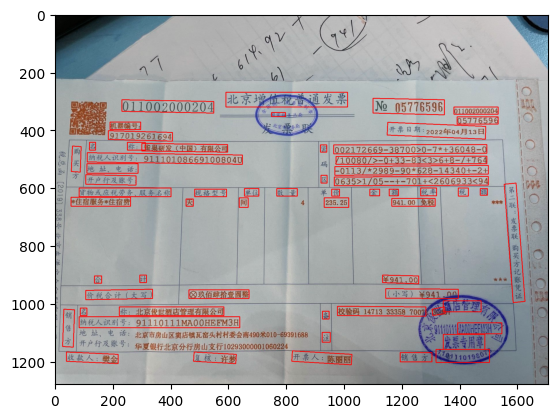

In [95]:
_, im_buf_arr = cv2.imencode(".jpg", img)
img_buffer = im_buf_arr.tobytes()

h, w = img.shape[:2]
vis_img = np.ones((h, w, 3), dtype=np.uint8) * 255
vis_img[:, :w] = img
ocr_data = ocr_res[0]["data"]
boxes = [res["text_box_position"] for res in ocr_data]
for i, box in enumerate(boxes):
  new_box = [[box[0], box[1]], [box[2], box[1]], [box[2], box[3]],
                   [box[0], box[3]]]
  Pts = np.array([new_box], np.int32)
  cv2.polylines(
    vis_img, [Pts.reshape((-1, 1, 2))],
    True,
    color=(255, 0, 0),
    thickness=2)

plt.imshow(vis_img)

Init the SDMG-R KIE model

In [103]:
def read_class_list(filepath):
    dict = {}
    with open(filepath, "r") as f:
        lines = f.readlines()
        for line in lines:
            key, value = line.split(" ")
            dict[key] = value.rstrip()
    return dict

with open("./configs/kie/kie_unet_sdmgr_fapiao_hub.yml", "r") as stream:
    config = yaml.safe_load(stream)
global_config = config['Global']
model = build_model(config['Architecture'])
load_model(config, model)
model.eval()
class_path = config['Global']['class_path']
idx_to_cls = read_class_list(class_path)
transforms = []
for op in config['Eval']['dataset']['transforms']:
    transforms.append(op)
ops = create_operators(transforms, global_config)

[2022/08/31 16:20:03] ppocr INFO: resume from params/kie/best_accuracy


convert the inference result from OCR module to the input of KIE model

In [74]:

_, im_buf_arr = cv2.imencode(".jpg", img)
kie_input = [{
        "image": im_buf_arr.tobytes(),
        "label": [{
                "label": 1,
                "transcription": data["text"],
                "points": data["text_box_position"]
        } for data in res["data"]],
} for _, res in enumerate(ocr_res)]

Apply pre-process operators to input data, and then pass to KIE model and get inference result

In [130]:
import json
import paddle.nn.functional as F

output = []
for res in kie_input:
    label = json.dumps(res["label"], ensure_ascii=False)
    data = {
        "label": label,
        "image": res["image"]
    }
    batch = transform(data, ops)
    batch_pred = [0] * len(batch)
    for i in range(len(batch)):
        batch_pred[i] = paddle.to_tensor(
            np.expand_dims(
                batch[i], axis=0))
    node, edge = model(batch_pred)
    node = F.softmax(node, -1)
    max_value, max_idx = paddle.max(node, -1), paddle.argmax(node, -1)
    node_pred_label = max_idx.numpy().tolist()
    node_pred_score = max_value.numpy().tolist()
    annotations = res["label"]
    pred_res = {}
    for i, label in enumerate(node_pred_label):
        pred_score = '{:.2f}'.format(node_pred_score[i])
        pred_label = str(node_pred_label[i])
        if pred_label in idx_to_cls:
            pred_label = idx_to_cls[pred_label]
        pred_item = {
            'label': label,
            'transcription': annotations[i]['transcription'],
            'score': pred_score,
            'points': annotations[i]['points'],
        }
        if pred_label in pred_res:
            pred_res[pred_label].append(pred_item)
        else:
            pred_res[pred_label] = [pred_item]
    output.append(pred_res)

outputData = output[0]

pd.DataFrame(list(np.concatenate([[{
  **data, "label": key
} for data in outputData[key]] for key in outputData if key != 'Others']).flat))

,label,transcription,score,points
0,Fapiao_code,011002000204,1.00,"[[231, 296], [549, 302], [549, 342], [231, 336]]"
1,Fapiao_code,011002000204,1.00,"[[1380, 321], [1533, 321], [1533, 346], [1380,..."
2,Fapiao_no,Ne05776596,1.00,"[[1100, 291], [1347, 296], [1347, 348], [1100,..."
3,Fapiao_no,05776596,1.00,"[[1391, 355], [1533, 355], [1533, 380], [1391,..."
4,Issue_date,开票日期：2022年04月13日,1.00,"[[1151, 374], [1490, 388], [1489, 432], [1149,..."
5,Buyer_name,雀巢研发（中国）有限公司,0.99,"[[300, 447], [597, 451], [597, 477], [300, 473]]"
6,Buyer_tax_no,纳税人识别号：91110108669100804U,1.00,"[[111, 479], [648, 487], [648, 519], [111, 511]]"
7,Line_items_name,*住宿服务*住宿费,0.99,"[[55, 633], [261, 633], [261, 664], [55, 664]]"
8,Amount,235.25,0.96,"[[931, 635], [1016, 635], [1016, 668], [931, 6..."
9,Line_items_amount,941.00免税,0.51,"[[1165, 637], [1315, 637], [1315, 664], [1165,..."


Draw the bounding box and key information category on the fapiao image

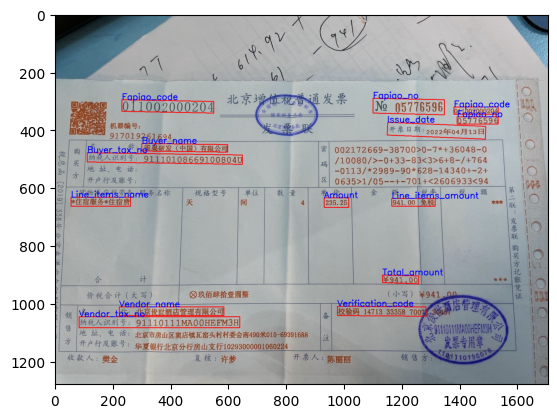

In [129]:
vis_kie_img = np.ones((h, w, 3), dtype=np.uint8) * 255
vis_kie_img[:, :w] = img
kie_res = output[0]
for key in kie_res:
  if key == 'Others':
    continue
  boxes = [res["points"] for res in kie_res[key]]
  for i, box in enumerate(boxes):
    new_box = box
    Pts = np.array([new_box], np.int32)
    cv2.polylines(
        vis_kie_img, [Pts.reshape((-1, 1, 2))],
        True,
        color=(255, 0, 0),
        thickness=2)
    x_min = int(min([point[0] for point in new_box]))
    y_min = int(min([point[1] for point in new_box]))
    cv2.putText(vis_kie_img, key, (x_min, y_min),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)


plt.imshow(vis_kie_img)